### Fundamentos de Series de Tiempo 

Una serie de tiempo es una secuencia de observaciones $\{X_t\}$ indexadas por el tiempo $t$, donde $t \in T$ y $T$ representa el conjunto de índices temporales (discreto o continuo). Matemáticamente, se puede expresar como:

$$X_t = f(t) + \epsilon_t$$

donde $f(t)$ representa la componente determinística (tendencia, estacionalidad) y $\epsilon_t$ es la componente estocástica o ruido aleatorio. El objetivo principal del análisis de series temporales es modelar la dependencia temporal entre las observaciones, es decir, $\text{Cov}(X_t, X_{t-k}) \neq 0$ para diferentes valores de rezago $k$.

Vamos a  analizar la serie del CO2 de Mauna Loa, disponible en `statsmodels` la representa las mediciones de concentración atmosférica de dióxido de carbono (en partes por millón, ppm) registradas en el observatorio de Mauna Loa (Hawái) desde finales de la década de 1950 hasta el 2001.


Dependiendo de la serie estos podrían ser algunos de los preprocesamientos sugeridos:

| Paso                            | Propósito               | Método sugerido               |
| ------------------------------- | ----------------------- | ----------------------------- |
| 1️⃣ Completar datos faltantes   | Continuidad temporal    | Interpolación lineal o eleiminar NA's         |
| 2️⃣ Definir frecuencia          | Regularizar la serie    | `.asfreq("MS")`               |
| 3️⃣ Transformar si es necesario | Log o diferencia        | No log, sí diferencias (1,12) |
| 4️⃣ Verificar estacionariedad   | Confirmar con ADF/KPSS  | `adfuller`, `kpss`            |
| 5️⃣ Escalar (opcional)          | Facilitar entrenamiento | `StandardScaler` o `MinMax`   |


In [1]:
#Obtener los datos
import pandas as pd
import statsmodels.api as sm

data = sm.datasets.co2.load_pandas().data
data.info() 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


La  serie presenta valores perdidos "NA's" por tanto se requiere hacer una interpolación, o elimininar esos valores. La interpolación se prefiere cunado los datos faltantes son pocos y sin ningún patrón aparente. Se recomienda eliminar cuando son mayores al 20% o 30%, ya qe la intrpolación poodría generar sesgos. En este caso son 59 datos faltantes que corresponden a un 2.5%. Se recomienda interpolar y dar formato a la serie.
 

In [2]:
# Convertir el índice a datetime
data.index = pd.to_datetime(data.index)
data = data.asfreq("W-SAT")  
print(data.info())              # index semanal regular

#convertiremos la serie a frecuencia mensual
y_m = data["co2"].resample("MS").mean().interpolate()  # mensual, inicio de mes
y = y_m.copy()
df = pd.DataFrame({"y": y})
df.describe


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB
None


<bound method NDFrame.describe of                      y
1958-03-01  316.100000
1958-04-01  317.200000
1958-05-01  317.433333
1958-06-01  316.529167
1958-07-01  315.625000
...                ...
2001-08-01  369.425000
2001-09-01  367.880000
2001-10-01  368.050000
2001-11-01  369.375000
2001-12-01  371.020000

[526 rows x 1 columns]>

### Analisis Exploratorio de la Serie

In [3]:
import plotly.graph_objects as go # type: ignore

# Crear la gráfica de la serie mensual de CO2
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y.index,
    y=y.values,
    mode='lines',
    name='CO2 (ppm)',
    line=dict(color='blue', width=1.5)
))

fig.update_layout(
    title='Serie Temporal de CO2 - Mauna Loa (Mensualizada)',
    xaxis_title='Fecha',
    yaxis_title='Concentración CO2 (ppm)',
    template='plotly_white',
    width=800,
    height=400
)

fig.show()

Vemos que la serie claramente tiene tendencia, posiblemente estacionalidad, para deteminar si es estacionaria o no, se debe realizar las pruebas de raices unitarias.

Para descomponer la serie se utiliza `seasonal_decompose` de la librería `statsmodels`

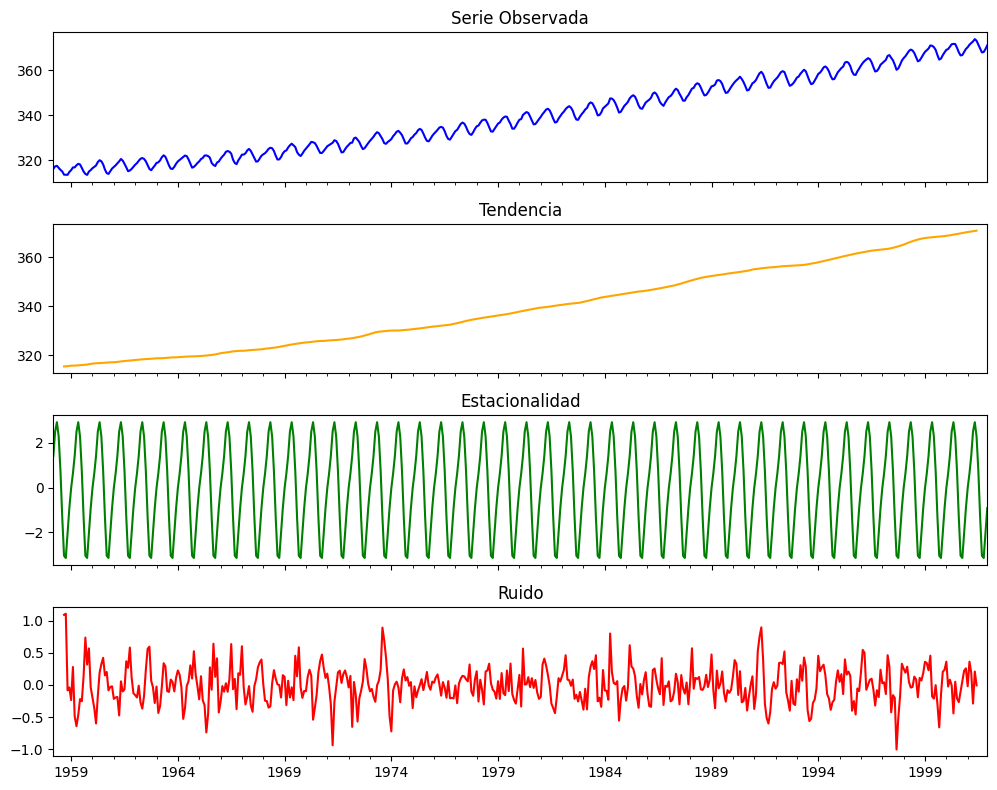

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomponer la serie
result = seasonal_decompose(y, model='additive')

# Graficar los componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

result.observed.plot(ax=ax1, title='Serie Observada', color='blue')
result.trend.plot(ax=ax2, title='Tendencia', color='orange')
result.seasonal.plot(ax=ax3, title='Estacionalidad', color='green')
result.resid.plot(ax=ax4, title='Ruido', color='red')

plt.tight_layout()
plt.show()

La descomposición de la serie de CO₂ de Mauna Loa evidencia una tendencia creciente sostenida y una estacionalidad anual estable, características de un proceso no estacionario con comportamiento aditivo. La tendencia refleja el incremento progresivo de las concentraciones atmosféricas de CO₂ a lo largo de las décadas, mientras que el patrón estacional se asocia a las variaciones cíclicas naturales de absorción y emisión de CO₂. El componente residual muestra fluctuaciones aleatorias de baja magnitud, indicando que los patrones sistemáticos de la serie están bien capturados y que su modelamiento requiere técnicas que consideren la tendencia y la estacionalidad

In [5]:
# prueba de Dickey-Fuller aumentada (ADF)
from statsmodels.tsa.stattools import adfuller  
adf_result = adfuller(y.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: 2.2328354398989183
p-value: 0.9989084530577083
Critical Values:
   1%, -3.4432119442564324
Critical Values:
   5%, -2.8672126791646955
Critical Values:
   10%, -2.569791324979607


Los resultados de la prueba de raíces unitarias ADF (Augmented Dickey-Fuller) indican que la serie no es estacionaria, ya que el estadístico ADF (2.23) es mayor que todos los valores críticos al 1%, 5% y 10%, y el p-valor (≈0.999) es muy superior a 0.05, por lo que no se rechaza la hipótesis nula de existencia de una raíz unitaria. En consecuencia, la serie presenta una tendencia o dependencia temporal persistente, lo que sugiere la necesidad de aplicar diferenciación o detrendización para lograr estacionariedad antes de su modelamiento.

#### Analizar la Autocorrelación

Utilizar las funciones de Autocorrelación (ACF) y Autocorrelación Parcial (PACF) para estudiar el grado de dependencia con los rezagos (puntos pasados)



<Figure size 1000x600 with 0 Axes>

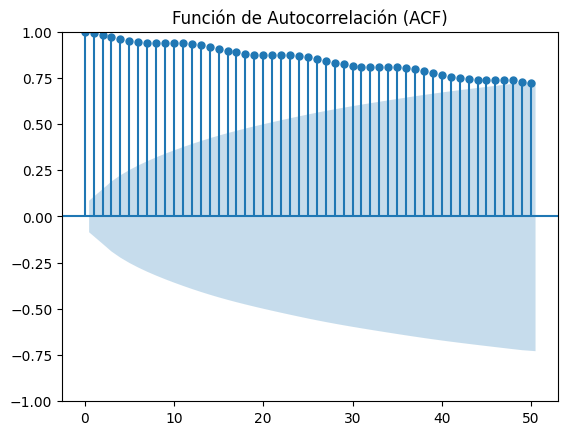

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt

# Graficar la función de autocorrelación (ACF)
plt.figure(figsize=(10, 6))
plot_acf(y, lags=50, alpha=0.05)
plt.title('Función de Autocorrelación (ACF)')
plt.show()

La gráfica de la Función de Autocorrelación (ACF) muestra coeficientes que disminuyen de forma lenta y gradual a medida que aumenta el rezago, manteniéndose todos positivos y significativamente distintos de cero. Este patrón es característico de una serie no estacionaria con tendencia, donde los valores presentes están fuertemente correlacionados con los pasados. En consecuencia, la serie presenta alta persistencia temporal y memoria larga, por lo que requiere aplicar una diferenciación para eliminar la tendencia y lograr estacionariedad antes del modelamiento.

<Figure size 1000x600 with 0 Axes>

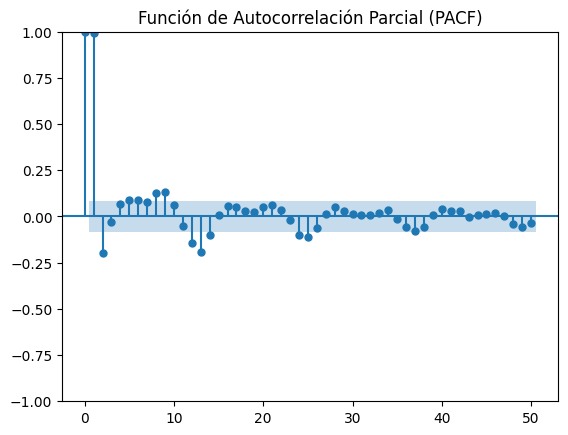

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf

# Graficar la función de autocorrelación parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(y, lags=50, alpha=0.05, method='ywm')
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.show()

La gráfica de la Función de Autocorrelación Parcial (PACF) muestra un alto valor significativo en el primer rezago y una rápida caída posterior hacia valores cercanos a cero, sin correlaciones parciales relevantes en rezagos mayores. Este patrón indica que la dependencia directa de la serie se concentra principalmente en su valor inmediatamente anterior, característica típica de un proceso autorregresivo de primer orden (AR(1)) o de una serie no estacionaria con fuerte persistencia temporal. En conjunto con la ACF, este comportamiento sugiere que la serie requiere diferenciación para eliminar la tendencia y estabilizar la media antes de aplicar un modelo ARIMA.